In [1]:
import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow as gpf

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

In [13]:
gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

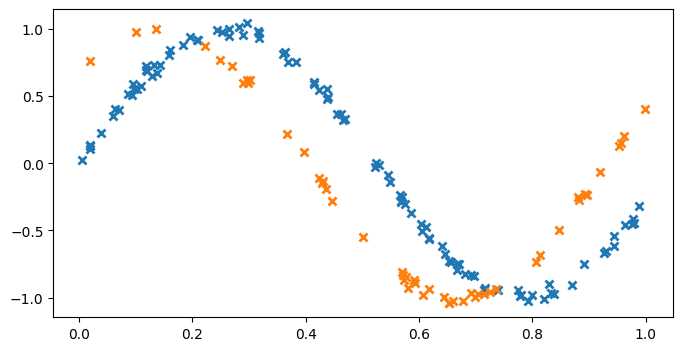

In [14]:
x1 = np.random.rand(100, 1)
x2 = np.random.rand(50, 1)

y1 = np.sin(6*x1) + np.random.randn(*x1.shape) * 0.03
y2 = np.sin(6*x2 + 0.7) + np.random.randn(*x2.shape) * 0.03

plt.figure(figsize=(8, 4))
plt.plot(x1, y1, 'x', mew=2)
plt.plot(x2, y2, 'x', mew=2)

In [15]:
x_augmented = np.vstack((np.hstack((x1, np.zeros_like(x1))), np.hstack((x2, np.ones_like(x2)))))
y_augmented = np.vstack((np.hstack((y1, np.zeros_like(y1))), np.hstack((y2, np.ones_like(y2)))))

In [16]:
x_augmented.shape

(150, 2)

In [17]:
x1.shape

(100, 1)

In [20]:
output_dim = 2
rank = 1
k1 = gpf.kernels.Matern32(1, active_dims=[0])
coreg = gpf.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])
coreg.W = np.random.rand(output_dim, rank)
kern = k1 * coreg

In [ ]:
output_dim = 2
rank = 1
kern = gpf.kernels.SharedIndependent(
    gpf.kernels.Matern32(1, active_dims=[0]) * gpf.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1]), output_dim=output_dim
)

In [18]:
lik = gpf.likelihoods.SwitchedLikelihood([gpf.likelihoods.Gaussian(), gpf.likelihoods.Gaussian()])
m = gpf.models.VGP([x_augmented, y_augmented], kernel=kern, likelihood=lik, num_latent_gps=1)

In [24]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss,
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": 1000},
    )
optimize_model_with_scipy(m)

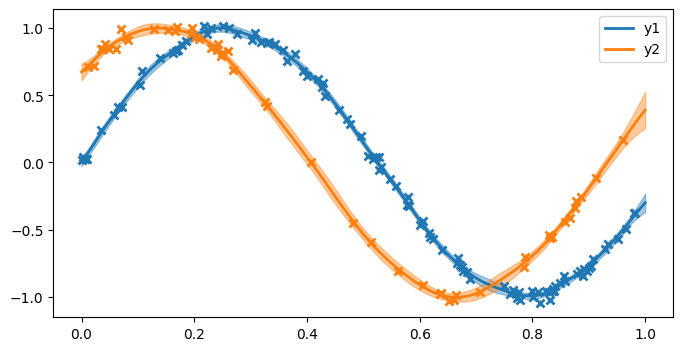

In [25]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(x[:, 0],
                     (mu - 2*np.sqrt(var))[:, 0],
                     (mu + 2*np.sqrt(var))[:, 0],
                     color=color, alpha=0.4)

def plot(m):
    plt.figure(figsize=(8, 4))
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(x1, y1, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'y1')

    line, = plt.plot(x2, y2, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'y2')

    plt.legend()

plot(m)

In [28]:
optimizer = gpf.optimizers.Adam()

AttributeError: module 'gpflow.optimizers' has no attribute 'Adam'

In [27]:
optimizer

In [10]:
from model.multi_task_gp import MultiTaskGP

In [21]:
lik = gpf.likelihoods.SwitchedLikelihood([gpf.likelihoods.Gaussian(), gpf.likelihoods.Gaussian()])

In [22]:
m = MultiTaskGP([x_augmented, y_augmented], kernel=kern, likelihood=lik)

In [24]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss,
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": 1000},
    )
optimize_model_with_scipy(m)

TypeError: in user code:

    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\optimizers\scipy.py", line 120, in _tf_eval  *
        loss, grads = _compute_loss_and_gradients(
    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\optimizers\scipy.py", line 223, in _compute_loss_and_gradients  *
        loss = loss_closure()
    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\models\training_mixins.py", line 60, in training_loss  *
        return self._training_loss()  # type: ignore
    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\models\model.py", line 54, in _training_loss  *
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    File "C:\Users\jackp\PycharmProjects\triumf_gaussian_process\model\multi_task_gp.py", line 20, in maximum_log_likelihood_objective  *
        return self.log_marginal_likelihood()
    File "C:\Users\jackp\PycharmProjects\triumf_gaussian_process\model\multi_task_gp.py", line 25, in log_marginal_likelihood  *
        ks = add_noise_cov(K, self.likelihood)
    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\utilities\model_utils.py", line 12, in add_noise_cov  *
        s_diag = tf.fill(tf.shape(k_diag), likelihood_variance)

    TypeError: Failed to convert elements of <gpflow.likelihoods.base.SwitchedLikelihood object at 0x000001A9F3F91A00> to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
